In [2]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt 
import warnings
warnings.simplefilter('ignore')

In [3]:
#download data
googl = pdr.DataReader('GOOGL', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30))

In [4]:
googl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-08-01,583.429993,570.299988,578.549988,573.599976,2213300,573.599976
2014-08-04,583.820007,572.260010,576.510010,582.270020,1519400,582.270020
2014-08-05,580.200012,570.309998,579.380005,573.140015,1643800,573.140015
2014-08-06,578.640015,567.450012,569.500000,574.489990,1322800,574.489990
2014-08-07,578.309998,569.429993,576.049988,571.809998,1163000,571.809998


In [5]:
googl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 589 entries, 2014-08-01 to 2016-11-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       589 non-null    float64
 1   Low        589 non-null    float64
 2   Open       589 non-null    float64
 3   Close      589 non-null    float64
 4   Volume     589 non-null    int64  
 5   Adj Close  589 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 32.2 KB


Text(0.5, 1.0, 'Original Data')

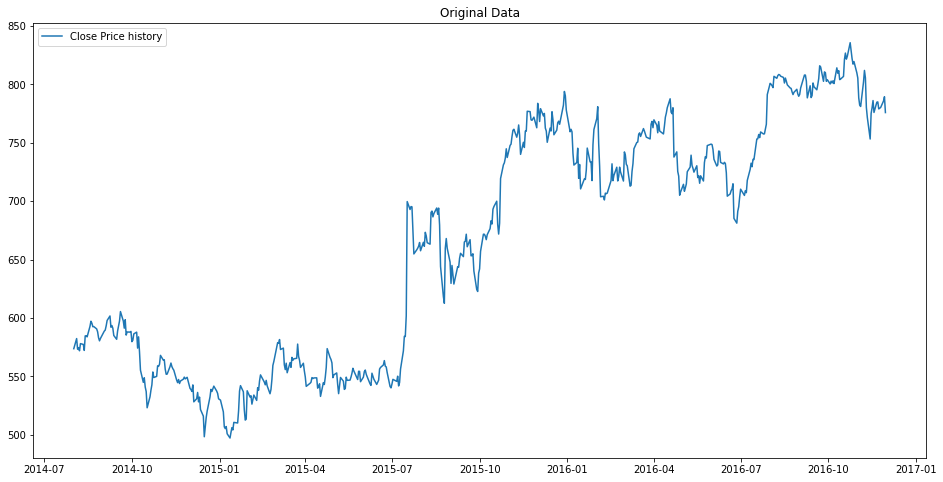

In [6]:
plt.figure(figsize=(16,8))
plt.plot(googl['Close'], label='Close Price history')
plt.legend()
plt.title('Original Data')

## **ARIMA Model**

**CASE:i**

In [7]:
from statsmodels.tsa.arima_model import ARIMA

In [8]:
!pip3 install pmdarima

In [9]:
data = googl['Close'].to_numpy()
train = data[:int(len(data)*0.8)]
test = data[int(len(data)*0.8):]
date = (googl.index)

In [10]:
import pmdarima as pm
st_model = pm.auto_arima(train, start_p=1, start_q=1,max_p=3, max_q=3, m=1,start_P=0, seasonal=False,d=1, D=0, trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3533.844, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3531.503, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3531.867, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3531.921, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3530.012, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.702 seconds


In [11]:
history = [x for x in train]
model_predictions = []
N_test_observations = len(test)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[time_point]
    history.append(true_test_value)

In [12]:
rmse1 = np.sqrt(np.mean(np.power((np.array(test)-np.array(model_predictions)),2)))
print('RMSE value using ARIMA model',rmse1)

RMSE value using ARIMA model 52.73219034288831


Text(0.5, 1.0, 'Prediction using ARIMA')

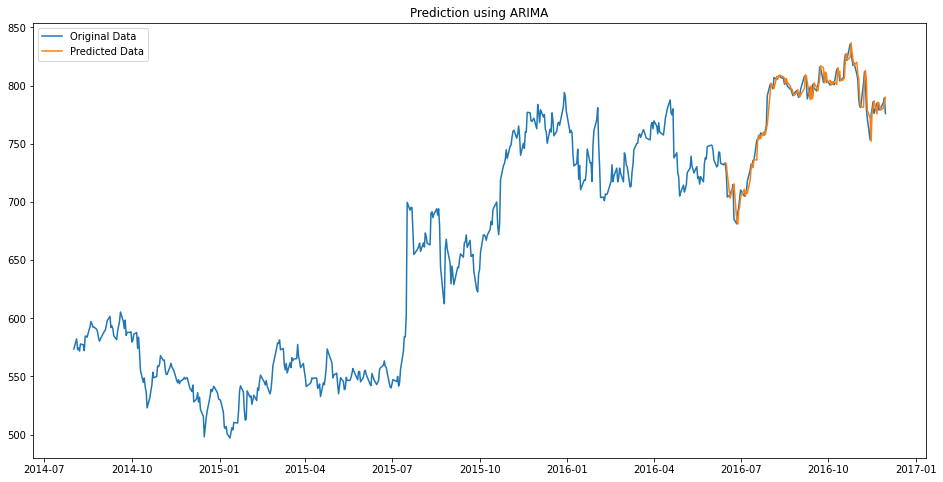

In [13]:
plt.figure(figsize=(16,8))
plt.plot(date,data, label='Original Data')
plt.plot(date[int(0.8*len(data)):],model_predictions, label='Predicted Data')
plt.legend()
plt.title('Prediction using ARIMA')

**CASE:ii**

**ARIMA by fitting whole dataset at a time**

In [14]:
model=ARIMA(data,order=(1,1,1))
model_fit = model.fit()

In [15]:
forecast = model_fit.predict(typ='levels')

In [16]:
rmse_a = np.sqrt(np.mean(np.power((np.array(test[1:])-np.array(forecast[int(len(data)*0.8):])),2)))
print('RMSE value using ARIMA model',rmse_a)

RMSE value using ARIMA model 8.428799407516538


Text(0.5, 1.0, 'Prediction using ARIMA (fitted whole data at a time)')

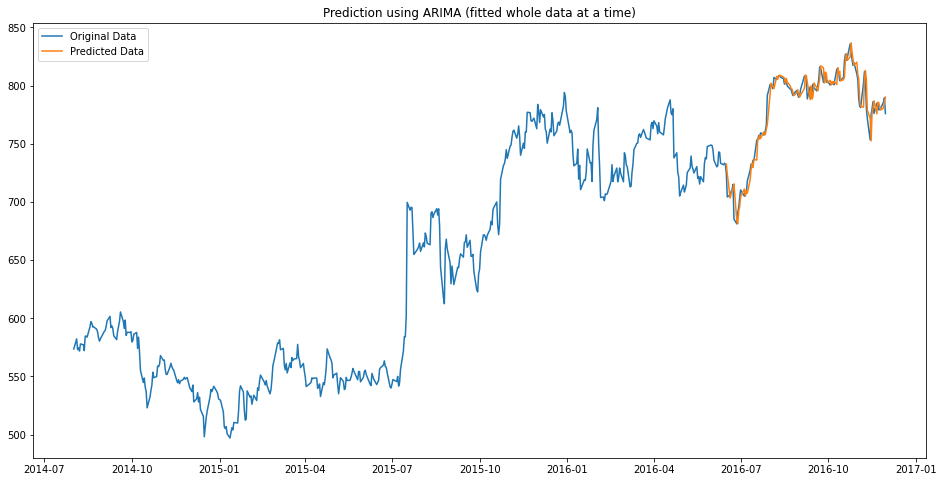

In [17]:
plt.figure(figsize=(16,8))
plt.plot(date,data, label='Original Data')
plt.plot(date[int(0.8*len(data))+1:],forecast[int(0.8*len(data)):], label='Predicted Data')
plt.legend()
plt.title('Prediction using ARIMA (fitted whole data at a time)')

## **Exponential Smoothing**

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [19]:
n = int(len(googl["Close"])*0.8)
data = googl['Close'].to_numpy()
train2 = data[:n]
test2 = data[n:]
date = (googl.index)

In [20]:
Exp_model = ExponentialSmoothing(googl.Close,trend='mul',seasonal='mul',seasonal_periods=4)
googl['Pred_Exp'] = Exp_model.fit(smoothing_level = 0.9,smoothing_slope= 0.1,smoothing_seasonal = 0.2).fittedvalues.shift(0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [21]:
rmse2 = np.sqrt(np.mean(np.power((np.array(test2)-np.array(googl.Pred_Exp[n:])),2)))
print('RMSE value using Exponential Smoothing model: ',rmse2)

RMSE value using Exponential Smoothing model:  9.584771173799444


Text(0.5, 1.0, 'Prediction using Exponential Smoothing')

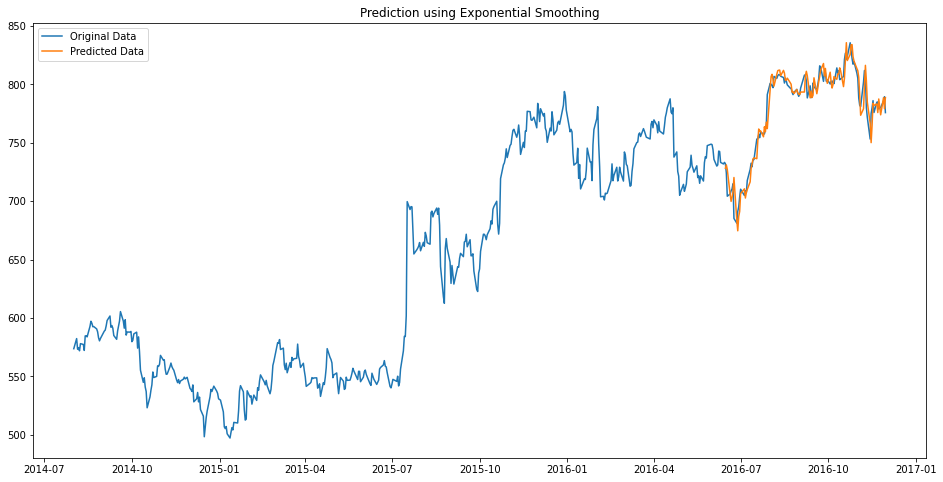

In [22]:
plt.figure(figsize=(16,8))
plt.plot(date,data, label='Original Data')
plt.plot(date[n:],googl.Pred_Exp[n:], label='Predicted Data')
plt.legend()
plt.title('Prediction using Exponential Smoothing')

## **LSTM Model**

In [23]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [24]:
df1=googl['Close']
date = (googl.index)

In [25]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [26]:
##splitting dataset into train and test split
training_size = int(0.8*len(df1))
test_size = len(df1)-training_size
train_data = df1[0:training_size]
test_data = df1[training_size:len(df1)] 

In [27]:
# convert an array of values into a dataset matrix 
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0]) 
	return np.array(dataX), np.array(dataY) 

In [28]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [29]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [30]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
8/8 [==============================] - 7s 241ms/step - loss: 0.1997 - val_loss: 0.1815
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0368 - val_loss: 0.0020
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0196 - val_loss: 0.0742
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0171 - val_loss: 0.0029
Epoch 5/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0095 - val_loss: 0.0082
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0066 - val_loss: 0.0033
Epoch 7/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 8/100
8/8 [==============================] - 0s 29ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 9/100
8/8 [==============================] - 0s 33ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 10/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 11/100
8/8 [

In [33]:
# prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [34]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [35]:
Y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(ytest.reshape(-1, 1))

In [36]:
# Train data RMSE
rmse3 = np.sqrt(np.mean(np.power((np.array(Y_train)-np.array(train_predict)),2)))
print('RMSE value of train data using LSTM model',rmse3)

RMSE value of train data using LSTM model 17.38938482693243


In [37]:
# Test Data RMSE
rmse4 = np.sqrt(np.mean(np.power((np.array(Y_test)-np.array(test_predict)),2)))
print('RMSE value of test data using LSTM model',rmse4)

RMSE value of test data using LSTM model 15.536027309717877


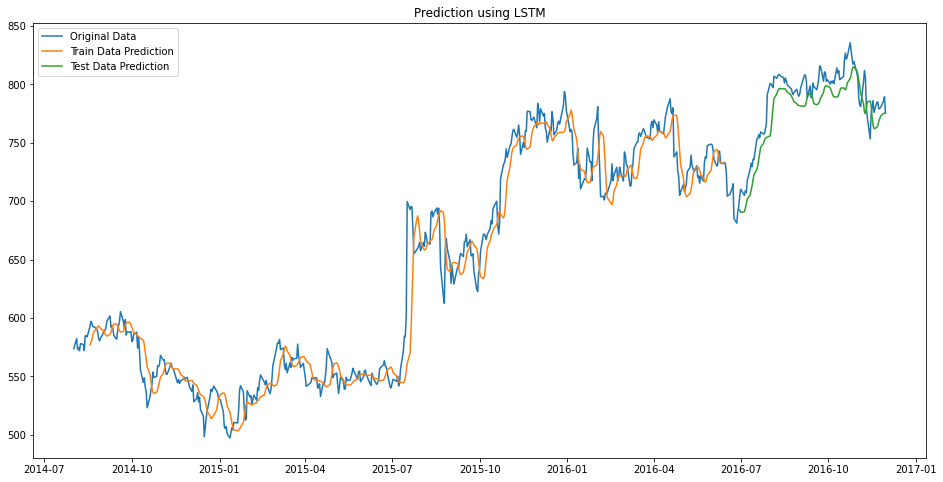

In [38]:
# plot baseline and predictions
look_back=10
plt.figure(figsize=(16,8))
plt.plot(date,scaler.inverse_transform(df1), label='Original Data')
plt.plot(date[look_back+1:training_size],train_predict, label='Train Data Prediction')
plt.plot(date[training_size+look_back+1:],test_predict, label='Test Data Prediction')
plt.legend()
plt.title('Prediction using LSTM')
plt.show()

## **Inference**

For a taken parameter, RMSE value on test data using 

(1) ARIMA Model:

(i)Implemented by updating training data after each prediction: 52.73219034288831  

(ii)Implemented by fitting all data at a time: 8.428799407516538

(2) Exponential Smoothing: 9.584771173799444

(3) LSTM: 15.536027309717877

So from RMSE and plot we can say that ARIMA and Exponential smoothing predicts better for a taken parameters. In actual, above sentence can not be said. Statistical models like ARIMA(case:ii) , Exponential smoothing are not training the model like DL,ML model. 

Here, ARIMA is implemented by updating training data after each prediction(case:i). Now, we can compare it with ML models. So now if we see the RMSE value LSTM performs better but from graph we think ARIMA is fitting better.  

Also, if we give high time-step in LSTM and data available is large enough, It can predict much more accurate. 

So from  this, conclusion is that machine/deep learning models can be improved by tuning the parameter and can predict efficiently compare to stats model. But in our case, ARIMA (case:ii) performs better for a taken parameter.. 